# Keras generator with targets modified

## Context
Dataset of images with coordinates as targets (e.g., vertices of a shape, coordinates for body landmarks). 

We want to **augment** the dataset, but we need a way to implement the **ImageDataGenerator** to modify the **target** variables according to image transformation (for example, if the image is flipped horizontally, the target coordinates must be **flipped also**).

In [1]:
from platform import python_version

print(python_version())

3.9.13


In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
# from numpy.random import seed
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import os

In [4]:
# Randomizer
seed(16)

## We package the generator as a class
A simple Keras Generator with **modified target Y** as we apply transformation on image **X**

In [5]:
# Based on: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class MyDataGenerator(Sequence):
    'A simple Keras Generator with modified target Y as we apply transformation on image X'

    def __init__(self, list_IDs: [int], x_set, y_set, batch_size: int=32, dim: tuple=(70, 70), n_channels: int=1, n_vertices: int=4, shuffle: bool=True, horiz_flip_percent: float=0, vert_flip_percent: float=0):
        'Initialization'
        self.dim = dim
        self.im_size = dim[0]
        self.batch_size = batch_size
        self.x_set = x_set
        self.y_set = y_set
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_vertices = n_vertices
        self.shuffle = shuffle
        self.horiz_flip_percent = horiz_flip_percent
        self.vert_flip_percent  = vert_flip_percent
        self.on_epoch_end()

    def __len__(self) -> int:
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index: int):
        'Generate one batch of data'
        # 1. Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # 2. Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # 3. Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp: [int]):
        'Generates data containing batch_size samples'  # X : (nb_samples, *dim, nb_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_vertices * 2))
        indices_lr = np.random.choice(100, self.batch_size, replace=False)
        indices_ud = np.random.choice(100, self.batch_size, replace=False)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            image = np.array(self.x_set[ID], copy=True)
            label = np.array(self.y_set[ID], copy=True)
            nb_labels = len(label)

            # Perform modification on both X (the image) and y (the vertices)
            if (indices_lr[i] < self.horiz_flip_percent):  # Flip Left - Right
                # Modify the Image
                image = np.fliplr(image)
                # Modify the label
                for m in range(nb_labels):
                    if m % 2 == 0:
                        label[m] = 1 - label[m] # Flip the x

            if (indices_ud[i] < self.vert_flip_percent):  # Flip Up - Down
                # Modify the Image
                image = np.flipud(image)
                # Modify the label
                for m in range(nb_labels):
                    if m % 2 == 1:
                        label[m] = 1 - label[m] # Flip the y

            X[i,] = image
            y[i]  = label

        return X, y

In [6]:
# Indexes of images
# Only index 0 is used as there is only 1 image
indexes = [0]  

## Show an example of an image from Mix on Pix's training data

In [7]:
# We will transform the image of a Triangle
image_size = 70 # Square images 70,70
image_filename = "./images/triangle.20190701225733.1.png"
img = load_img(image_filename)  # image is a Black on White PIL image

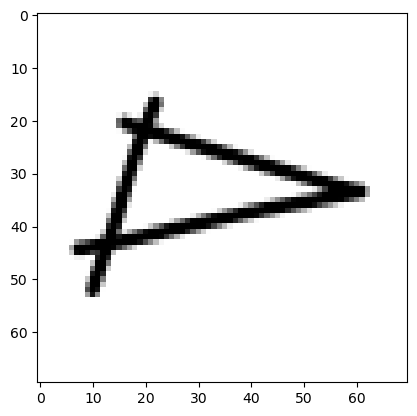

In [8]:
# Original image
g = plt.imshow(img)

In [9]:
# Labels also from training data
vertices = [0.18, 0.64, 0.29, 0.31, 0.85, 0.49]  # x1,y1 x2,y2 x3,y3 where 0,0 is top left and 1,1 is botton right
nb_vertices = len(vertices) // 2

***

In [10]:
xb = img_to_array(img)  # xb is a Numpy array with shape (70, 70, 3)

xb = np.expand_dims(xb, axis=0) # xb is now (1, 70, 70, 3)
xb /= 255. # all value are now between 0 and 1
xb = xb[:, :, :, 0]  # For a gray image, the first layer is enough.
xb = xb.reshape(1, image_size, image_size, 1)  #  xb is now in the expected format for a batch of 1 image

yb = np.array(vertices) # Shape (6,) if 3 vertices
yb = yb.reshape((1,) + yb.shape) # Reshaped to (1,6), the expected format for a batch of labels for 1 images

In [11]:
xb.shape

(1, 70, 70, 1)

In [12]:
yb.shape

(1, 6)

## Prepare the generator

In [13]:
# We prepare a generator where we do horizontal and vertical flip of the image and labels
datagenTest = MyDataGenerator(indexes, xb, yb, batch_size=1, \
                              n_vertices=nb_vertices, \
                              horiz_flip_percent=50, \
                              vert_flip_percent=50)

In [14]:
def plot_sample(X, y, axs):
    axs.imshow(X.reshape(image_size, image_size), cmap="gray") # Put the Image
    y = y.ravel()
    axs.scatter(image_size * y[0::2], image_size * y[1::2], c='orange') # Add the labels as orange dots

## Generate and display the images and the **modified labels**.
Note that the orange dots (the labels) **follow** the image transformations

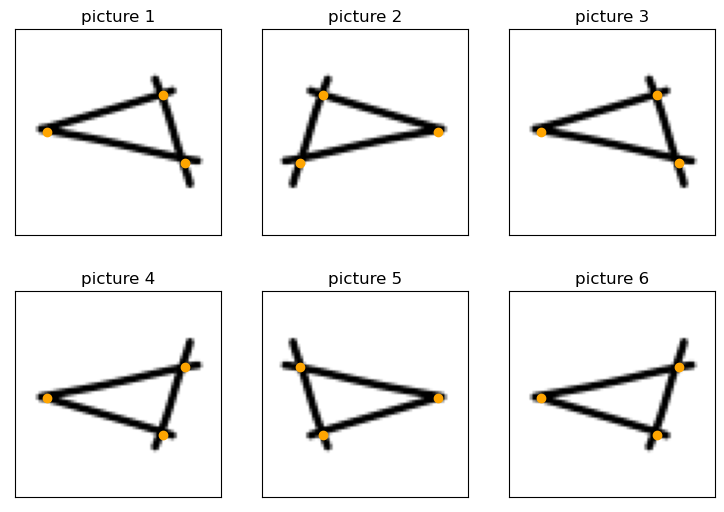

In [16]:
fig = plt.figure(figsize=(7, 5))
fig.subplots_adjust(hspace=0.1,wspace=0.2,
                    left=0,right=1,bottom=0,top=1)
nb_pictures = 6

for i_pic in range(nb_pictures):
    x,y = datagenTest.__getitem__(0) # <--- Calling the Generator here
    
    ax  = fig.add_subplot(nb_pictures // 3, 3, i_pic + 1, xticks=[], yticks=[])
    plot_sample(x, y, ax)
    ax.set_title("picture " + str(i_pic + 1))
plt.show()    

***